In [1]:
notebook_id = "210"

<a id="ID_top"></a>
## Adjacency matrix and network chart

This workflow takes live files and calls on functions in `script_adj_matrix_plot.py` to create adjancency matrices and network graph

#### Notebook sections:
    
|| [0|Top](#ID_top) || [1|Part1](#ID_part1) || [2|Part2](#ID_part2) || [3|Part3](#ID_part3) || [4|Part4](#ID_part4) || [5|Part5](#ID_part5) ||

### Packages

In [2]:
# %load s_package_import
# package library, use to ensure consistency across notebooks, refresh periodically
# general packages
import os # use with os.listdir(_path_)
import requests
import csv
import time
from datetime import datetime
from shutil import copyfile

#temp check
#from shutil import make_archive
import zipfile #notebook

# data analysis packages
import pandas as pd
pd.options.display.max_columns = None # don't truncate columns
#pd.options.display.max_rows = None

import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import descartes
import pycountry

# custom scripts
import s_file_export
import s_filepaths
import s_un_comtrade_extract as s_un
import s_adj_matrix_plot

#=== network analysis
import networkx as nx
#=== gavity modelling
import gme as gme

#=== distance datasets
import wbdata


/Users/antonios/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#### Import module and declare path variables
`import s_filepaths.py`

In [3]:
# import ref file
import s_filepaths

# declare local variables to work with
path_raw = s_filepaths.path_raw
path_raw_dl = s_filepaths.path_raw_dl
path_store = s_filepaths.path_store
path_live = s_filepaths.path_live
path_image = s_filepaths.path_images
path_analysis = s_filepaths.path_analysis

<a id="ID_part2"></a>
### Part 2 | Load files
|| [0|Top](#ID_top) || [1|Part1](#ID_part1) || [2|Part2](#ID_part2) || [3|Part3](#ID_part3) || [4|Part4](#ID_part4) || [5|Part5](#ID_part5) ||

In [4]:
# list of all files
os.listdir(path_live)

# list of file names that can be read with same rule
filename = "125_input_scope_country.csv.gzip"

Load data directly from compressed file to avoid GitHub issues with storage

In [5]:
# Load data
df_network_country = pd.read_csv(f"{path_live}{filename}",compression= "gzip")
df_network_country.head()

,year,country_d,iso3_d,dynamic_code_d,landlocked_d,island_d,region_d,gdp_pwt_const_d,pop_d,lat_d,lng_d,country_o,iso3_o,dynamic_code_o,landlocked_o,island_o,region_o,pop_o,lat_o,lng_o,contiguity,distance,bri_year_d,bri_flag_d,economic_distance,de_min_max,institutional_distance,di_min_max,Import_value,rtCode,rt3ISO,ptCode,pt3ISO,Export_value
0,2016,United Arab Emirates,ARE,ARE,0,0,middle_east,NaN,NaN,25.094378,55.454674,Portugal,PRT,PRT,0,0,europe,NaN,39.310741,-10.883486,0,6154.4214,2017.0,1.0,32364.307560,0.284975,0.411195,0.065377,2.183510e+08,620.0,PRT,784.0,ARE,1.794034e+08
1,2016,Azerbaijan,AZE,AZE,0,0,europe,NaN,NaN,40.362438,47.255833,Kuwait,KWT,KWT,0,0,middle_east,NaN,29.279369,47.930035,0,1236.6086,2015.0,1.0,30314.327882,0.266924,0.952483,0.151438,3.530921e+06,414.0,KWT,31.0,AZE,1.235241e+06
2,2016,Belgium,BEL,BEL,0,0,europe,NaN,NaN,50.691814,4.581812,Cambodia,KHM,KHM,0,0,south_east_asia,NaN,12.320902,104.874400,0,9693.0625,NaN,NaN,44933.919861,0.395653,4.862857,0.773159,3.670375e+08,116.0,KHM,56.0,BEL,3.968047e+08
3,2016,China,CHN,CHN,0,0,east_asia,NaN,NaN,35.389668,114.002470,Belarus,BLR,BLR,1,0,europe,NaN,53.604687,27.802185,0,6904.3364,2013.0,1.0,4153.131454,0.036569,0.005028,0.000799,4.351889e+08,112.0,BLR,156.0,CHN,4.005118e+08
4,2016,Spain,ESP,ESP,0,0,europe,NaN,NaN,39.231297,-4.263840,Belgium,BEL,BEL,0,0,europe,NaN,50.691814,4.581812,0,1374.9351,NaN,NaN,11326.515268,0.099732,1.875707,0.298224,7.757618e+09,56.0,BEL,724.0,ESP,1.049398e+10


### Prepare data for visualisation

In [6]:
# returns adjancecy matrix [position 0] and list of pairs [1]
array_adjacency = s_adj_matrix_plot.f_adj_matrix(df_network_country,"iso3_o","iso3_d",p_col_full = "country_o",p_index_full = "country_d")

Start-up report | Two different equal count (75) columns are used.


In [7]:
# update formula to dynamically add network characteristics
list_of_distances = ["distance","institutional_distance","economic_distance","di_min_max","de_min_max"]
#list_of_distances_to_call = ["DD_dummy","DW","DE","DE_minmax","DI","DI_minmax"]

In [8]:
# distance attributes in edges: dw, di, de, di_min_max, de_min_max
list_of_distances_to_call = ["length","dw","de","de_min_max","di","di_min_max"]

In [9]:
network_country = s_adj_matrix_plot.f_graph(array_adjacency[1],df_network_country,p_group_of_countries = list(df_network_country.country_o.unique()),
                          p_edge_colour="grey",p_colour_group="red",p_seed = 1, 
                        p_weight = "de_min_max",p_visualise = True,p_edge_traits_columns=list_of_distances,
                                            p_fig_size = (60,60),p_dpi = 150,p_node_size = 500, p_node_font = 30
                                           )

nodes: 75
edges: 151


In [10]:
# Code to see all edges and attributes
#nx.get_edge_attributes(network_country,"di_min_max")
#network_country.edges.data()

**Test 2 | Shortest path test**

In [11]:
# Path test
path_start = "China"
path_end = "Germany"

print(list_of_distances_to_call)

['length', 'dw', 'de', 'de_min_max', 'di', 'di_min_max']


In [12]:
for entry in list_of_distances_to_call:
    
    print(f"Shortest path ({entry})| {path_start}=>{path_end} | \n\t{nx.nx.single_source_dijkstra(network_country,path_start,path_end,weight =entry)}")
    print("")

Shortest path (length)| China=>Germany | 
	(5, ['China', 'Kazakhstan', 'Russia', 'Belarus', 'Poland', 'Germany'])

Shortest path (dw)| China=>Germany | 
	(8981.218379999998, ['China', 'Mongolia', 'Russia', 'Belarus', 'Poland', 'Germany'])

Shortest path (de)| China=>Germany | 
	(42274.089594089, ['China', 'Kazakhstan', 'Russia', 'Latvia', 'Lithuania', 'Poland', 'Germany'])

Shortest path (de_min_max)| China=>Germany | 
	(0.3722324145392517, ['China', 'Kazakhstan', 'Russia', 'Latvia', 'Lithuania', 'Poland', 'Germany'])

Shortest path (di)| China=>Germany | 
	(5.402502622738384, ['China', 'Kazakhstan', 'Russia', 'Ukraine', 'Hungary', 'Slovakia', 'Czech Republic', 'Germany'])

Shortest path (di_min_max)| China=>Germany | 
	(0.8589584904457921, ['China', 'Mongolia', 'Russia', 'Ukraine', 'Hungary', 'Slovakia', 'Czech Republic', 'Germany'])



**Test 3 | Betweeness centrality**

In [13]:
# betweeness
betweeness_centrality = nx.algorithms.centrality.betweenness_centrality(network_country)

In [14]:
# Assign new names to list
list_of_distances = ["length","dw","de","de_min_max","di","di_min_max"]

# for every distance measure run the test
df_betweeness = pd.DataFrame(index = np.arange(0,len(betweeness_centrality)))

for distance in list_of_distances:
    print(f"Working on distance: {distance}")
    betweeness_centrality = nx.algorithms.centrality.betweenness_centrality(network_country,weight = distance, k = len(betweeness_centrality))
    temp_df = pd.DataFrame.from_dict(betweeness_centrality,orient = "index",columns=[distance]).reset_index()
    temp_df.columns = [f"Country ({distance})",distance]
    temp_df = temp_df.sort_values(by = distance, ascending = False).reset_index(drop = True).copy()
    
    df_betweeness = df_betweeness.merge(temp_df,how="left",left_index = True,right_index = True).copy()
    
    

Working on distance: length
Working on distance: dw
Working on distance: de
Working on distance: de_min_max
Working on distance: di
Working on distance: di_min_max


In [15]:
df_betweeness.head(10)

,Country (length),length,Country (dw),dw,Country (de),de,Country (de_min_max),de_min_max,Country (di),di,Country (di_min_max),di_min_max
0,Russia,0.411291,Romania,0.388375,Russia,0.427373,Russia,0.426891,Russia,0.506201,Russia,0.505784
1,China,0.344245,Turkey,0.379119,Iran,0.351805,Iran,0.347098,China,0.348005,China,0.349247
2,Ukraine,0.223813,Bulgaria,0.378008,Latvia,0.320190,Latvia,0.318290,Iran,0.311567,Hungary,0.310416
3,Iraq,0.217327,Iran,0.372825,Poland,0.316673,Poland,0.315900,Hungary,0.301659,Iran,0.310331
4,Turkey,0.203525,Hungary,0.274343,Lithuania,0.308775,Lithuania,0.308775,Kazakhstan,0.278802,Kazakhstan,0.260871
5,Iran,0.201440,Pakistan,0.268049,China,0.246792,Azerbaijan,0.240175,Bulgaria,0.252351,Bulgaria,0.252203
6,Germany,0.169642,India,0.260644,Kazakhstan,0.237891,Kazakhstan,0.231259,Turkey,0.248843,Turkey,0.248014
7,Poland,0.165709,Iraq,0.218067,Azerbaijan,0.237483,China,0.228281,Azerbaijan,0.239541,Azerbaijan,0.239541
8,Kazakhstan,0.146986,Austria,0.200666,Germany,0.230314,Germany,0.227316,Ukraine,0.223654,Iraq,0.216586
9,Thailand,0.128193,Myanmar,0.182525,Iraq,0.223991,Iraq,0.222880,Iraq,0.216586,Ukraine,0.206066


In [16]:
# Export .csv
bc_filename = "betweeness_centrality"
s_file_export.f_df_export(df_betweeness,bc_filename,p_compression=None,p_loc2=path_analysis,p_loc2_pre="analysis_",p_file_id=f"{notebook_id}_")

No compression
Export | ../Data/1_raw_processed_backup/210_store_betweeness_centrality_20200813_0110.csv | COMPLETE
COPY   | ../Data/3_analysis/210_analysis_betweeness_centrality.csv | COMPLETE


In [17]:
#df_betweeness.tail(35)

**Test 1 | Centrality**

In [18]:
# Centrality
centrality = nx.algorithms.centrality.degree_centrality(network_country)

**Figure 10 | Country degree histogram**

#### Degree distribution
Code from [here](https://networkx.github.io/documentation/stable/auto_examples/drawing/plot_degree_histogram.html) only amedment done is remaping variables and some stylistic changes.

In [19]:
import collections

In [20]:
outdeg = network_country.degree()
to_highlight = [n[0] for n in outdeg if outdeg[n[0]] >= 8]
normal = [n[0] for n in outdeg if outdeg[n[0]] < 8]

In [21]:
to_highlight

['China', 'Germany', 'Russia', 'Serbia']

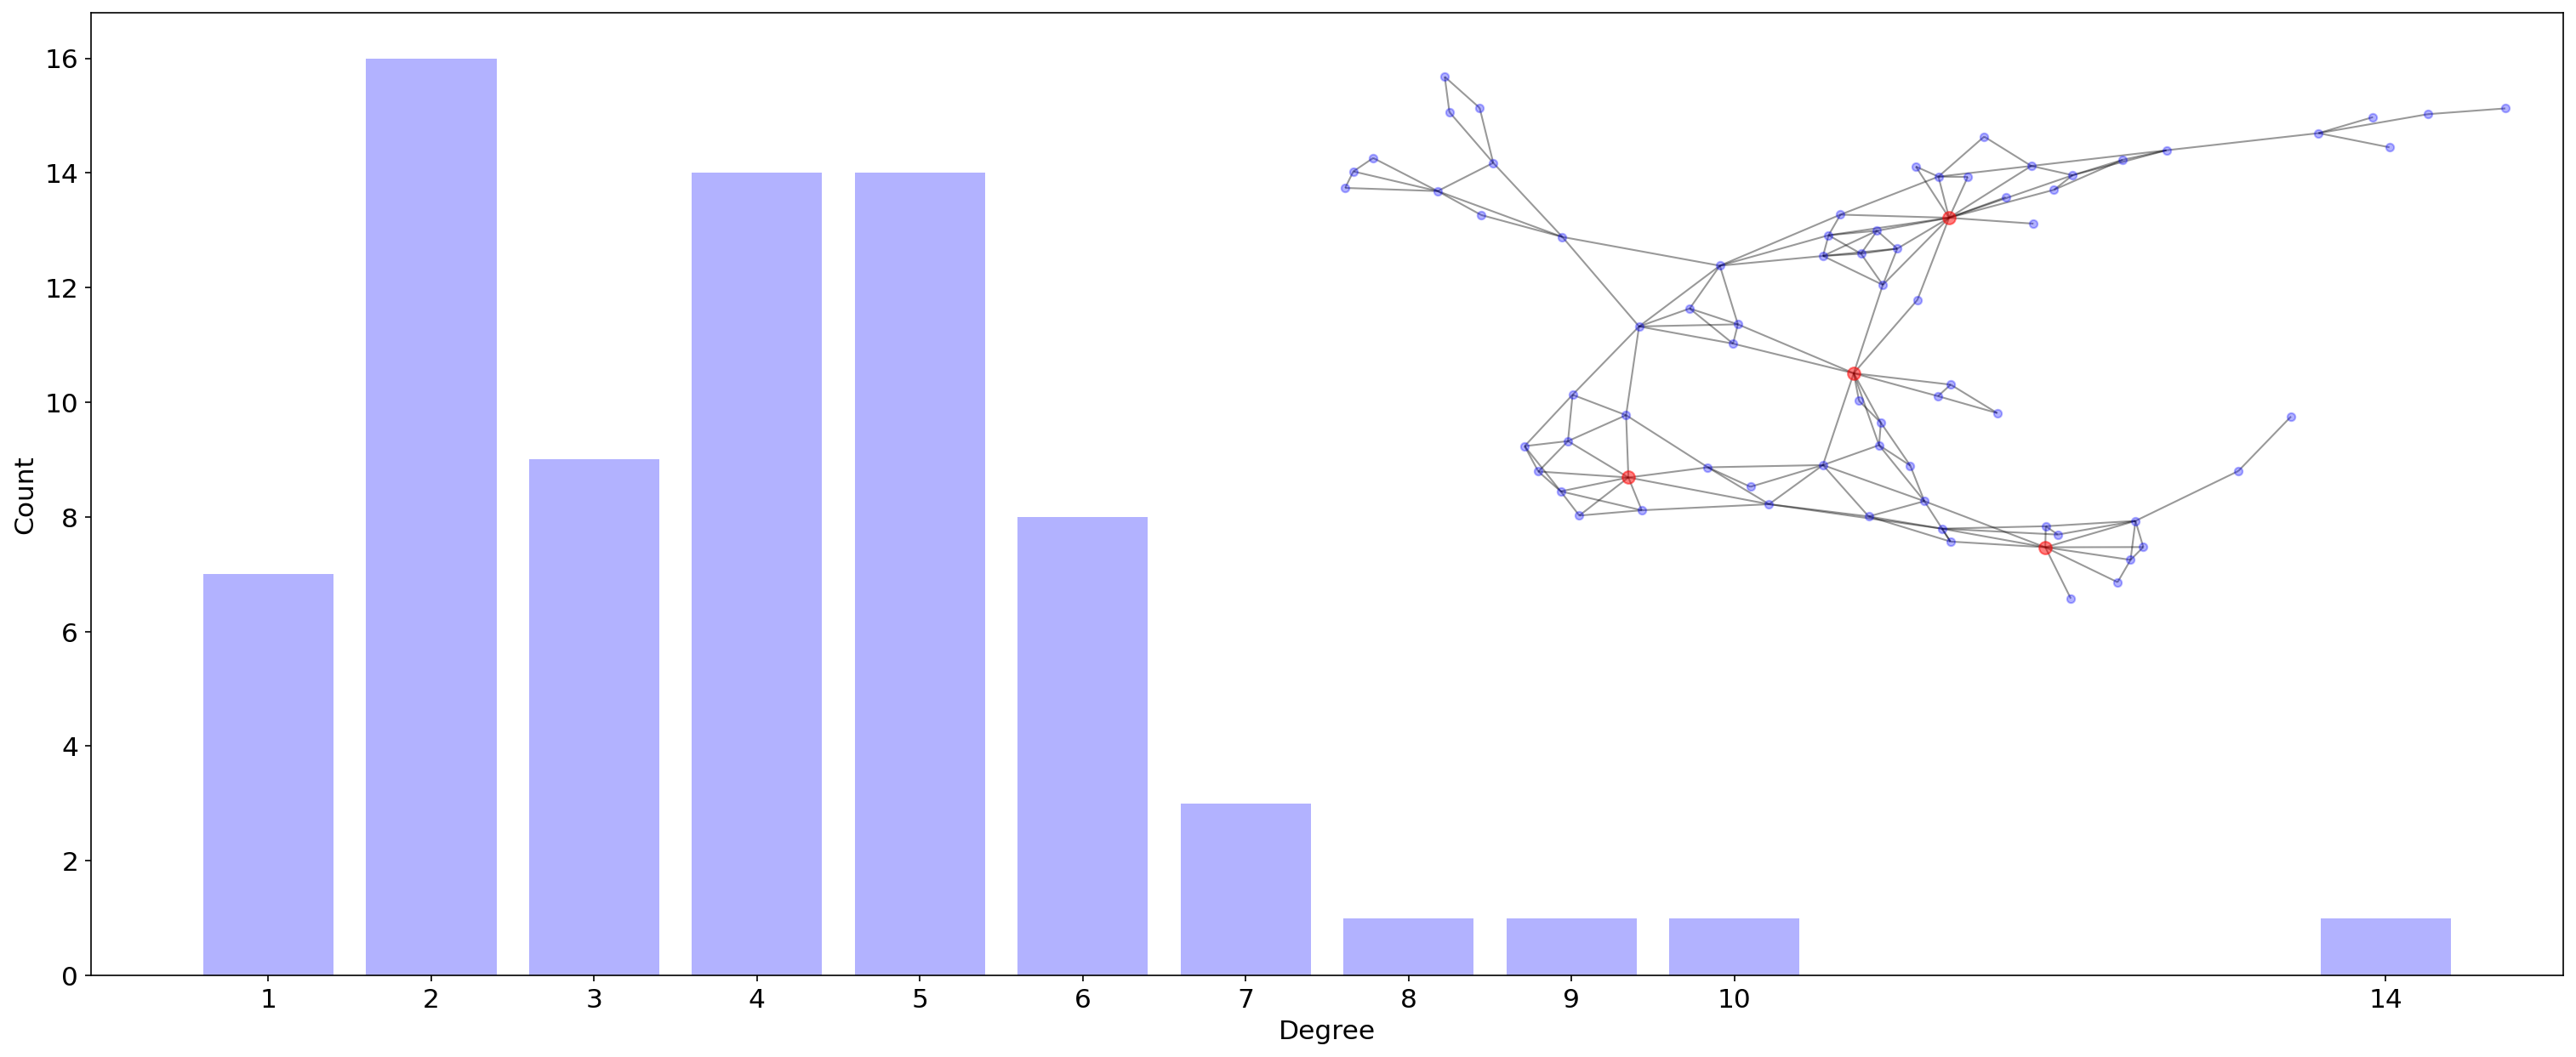

In [22]:
degree_sequence = sorted([d for n, d in network_country.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize = (25,10),dpi = 150)
plt.bar(deg, cnt, width=0.80, color='b',alpha = 0.3)

#plt.title("Degree Histogram")
plt.ylabel("Count",fontsize = 15)
plt.xlabel("Degree", fontsize = 15)
ax.set_xticks([d + 0 for d in deg])
ax.set_xticklabels(deg,fontsize = 15)
ax.tick_params(axis='y', labelsize= 15) 

# draw graph in inset
plt.axes([0.5, 0.4, 0.4, 0.45])
Gcc = network_country.subgraph(sorted(nx.connected_components(network_country), key=len, reverse=True)[0])
pos = nx.spring_layout(network_country)
plt.axis('off')
nx.draw_networkx_nodes(to_highlight, pos, node_size=50,node_color = "red",alpha = 0.5,dpi=150)
#nx.draw_networkx_labels(to_highlight, pos, labels= to_highlight )
nx.draw_networkx_nodes(normal, pos, node_size=20,node_color = "blue",alpha = 0.3,dpi=150)
nx.draw_networkx_edges(network_country, pos, alpha=0.4,dpi=150)

plot_name = "country_degree_hist.png"
#plt.savefig(f"{path_image}{notebook_id}_{plot_name}",dpi = 300,transparent = True,pad_inches = 0,bbox_inches= "tight")
plt.show()

<a id="ID_part3"></a>
### Part 3 | Proper visualisation
|| [0|Top](#ID_top) || [1|Part1](#ID_part1) || [2|Part2](#ID_part2) || [3|Part3](#ID_part3) || [4|Part4](#ID_part4) || [5|Part5](#ID_part5) ||

In [23]:
break

SyntaxError: 'break' outside loop (<ipython-input-23-6aaf1f276005>, line 4)

In [ ]:
plt.figure(1,figsize = (60,60),dpi = 150)
nx.draw_spring(network_country, with_labels = True, font_weight = "light",node_size=500,font_size=25, seed = 1)
plt.show()